In [22]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from itertools import product
import joblib
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, TimestampType
from pyspark.sql.functions import pandas_udf, PandasUDFType

In [23]:
# --- SMAPE Function ---
def smape_kun(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    smape = np.mean(
        np.where(
            denominator != 0, 
            (np.abs(y_pred - y_true) * 200) / denominator, 
            0
        )
    )
    return np.nan_to_num(smape)  # Convert NaN to 0

In [25]:
# --- Hyperparameter Tuning & Cross-Validation ---
def prophet_crossval(train, params, initial='730 days', period='180 days', horizon='90 days'):
    try:
        model = Prophet(
            growth='logistic',  # Add this line
            interval_width=0.95,
            weekly_seasonality=True,
            yearly_seasonality=True,
            seasonality_mode=params['seasonality_mode'],
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale']
        ).add_country_holidays('US')
        
        model.fit(train) 
        
        # Cross-validation with error handling
        df_cv = cross_validation(
            model,
            initial=initial,
            period=period,
            horizon=horizon,
            parallel="processes"
        )
        
        # Calculate metrics
        df_p = performance_metrics(df_cv)
        smape_val = smape_kun(df_cv['y'], df_cv['yhat'])
        return {'params': params, 'smape': smape_val, 'rmse': df_p['rmse'].mean()}
    
    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        return {'params': params, 'smape': np.nan, 'rmse': np.nan}

In [31]:
# --- Load Data ---
df = pd.read_csv('exported_train.csv')
df['date'] = pd.to_datetime(df['date'])

# --- Enhanced EDA ---
print("Dataset Shape:", df.shape)
print("\nFirst 5 Entries:")
display(df.head())
print("\nDescriptive Statistics:")
display(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicate Check:")
print("Max duplicate count:", df.groupby(["item", "store", "date"]).size().max())

Dataset Shape: (781835, 4)

First 5 Entries:


,store,item,sales,date
0,1,1,13,2013-01-01
1,1,1,11,2013-01-02
2,1,1,14,2013-01-03
3,1,1,13,2013-01-04
4,1,1,10,2013-01-05



Descriptive Statistics:


,store,item,sales,date
count,781835.000000,781835.000000,781835.000000,781835
mean,5.482690,21.910154,52.897194,2015-07-02 04:50:32.944803072
min,1.000000,1.000000,0.000000,2013-01-01 00:00:00
25%,3.000000,11.000000,30.000000,2014-04-01 00:00:00
50%,5.000000,22.000000,48.000000,2015-07-02 00:00:00
75%,8.000000,33.000000,70.000000,2016-10-01 00:00:00
max,10.000000,43.000000,231.000000,2017-12-31 00:00:00
std,2.865993,12.359782,29.049578,NaN



Missing Values:
store    0
item     0
sales    0
date     0
dtype: int64

Duplicate Check:
Max duplicate count: 1


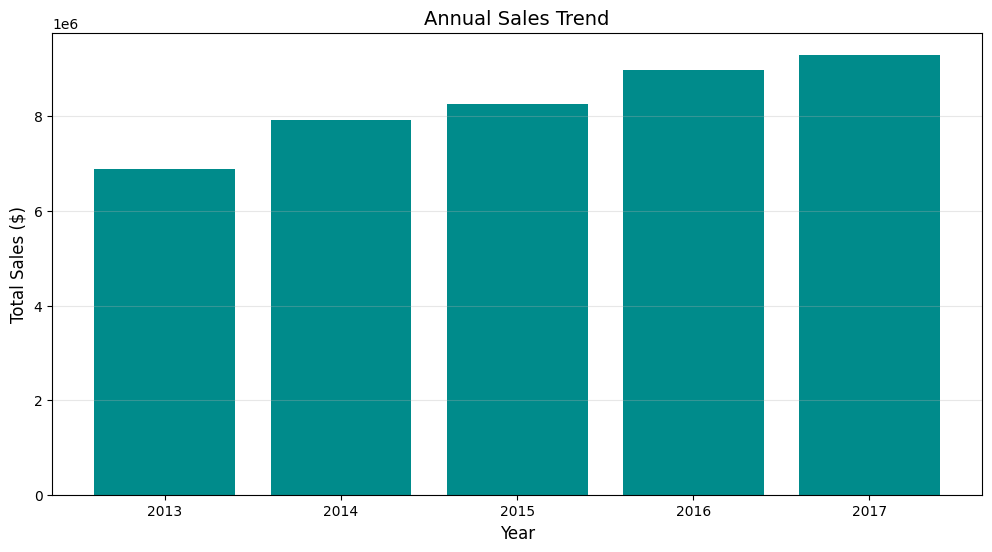

In [27]:
# --- Time Series Visualizations ---
# Annual Sales
df['year'] = df['date'].dt.year
yearly_sales = df.groupby('year')['sales'].sum()
plt.figure(figsize=(12,6))
plt.bar(yearly_sales.index.astype(str), yearly_sales.values, color='darkcyan')
plt.title('Annual Sales Trend', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()


Performing CV for 18 parameter combinations...


14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:33 - cmdstanpy - INFO - Chain [1] done processing
14:17:33 - cmdstanpy - INFO - Chain [1] done processing
14:17:33 - cmdstanpy - INFO - Chain [1] start processing
14:17:33 - cmdstanpy - INFO - Chain [1] done processing
14:17:33 - cmdstanpy - INFO - Chain [1] done processing
14:17:33 - cmdstanpy - INFO - Chain [1] done processing
14:17:34 - cmdstanpy - INFO - Chain [1] done processing
14:17:35 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1]


Best Parameters:
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Best SMAPE: 18.60%


14:18:41 - cmdstanpy - INFO - Chain [1] start processing
14:18:41 - cmdstanpy - INFO - Chain [1] done processing



Test Set SMAPE: 18.78%


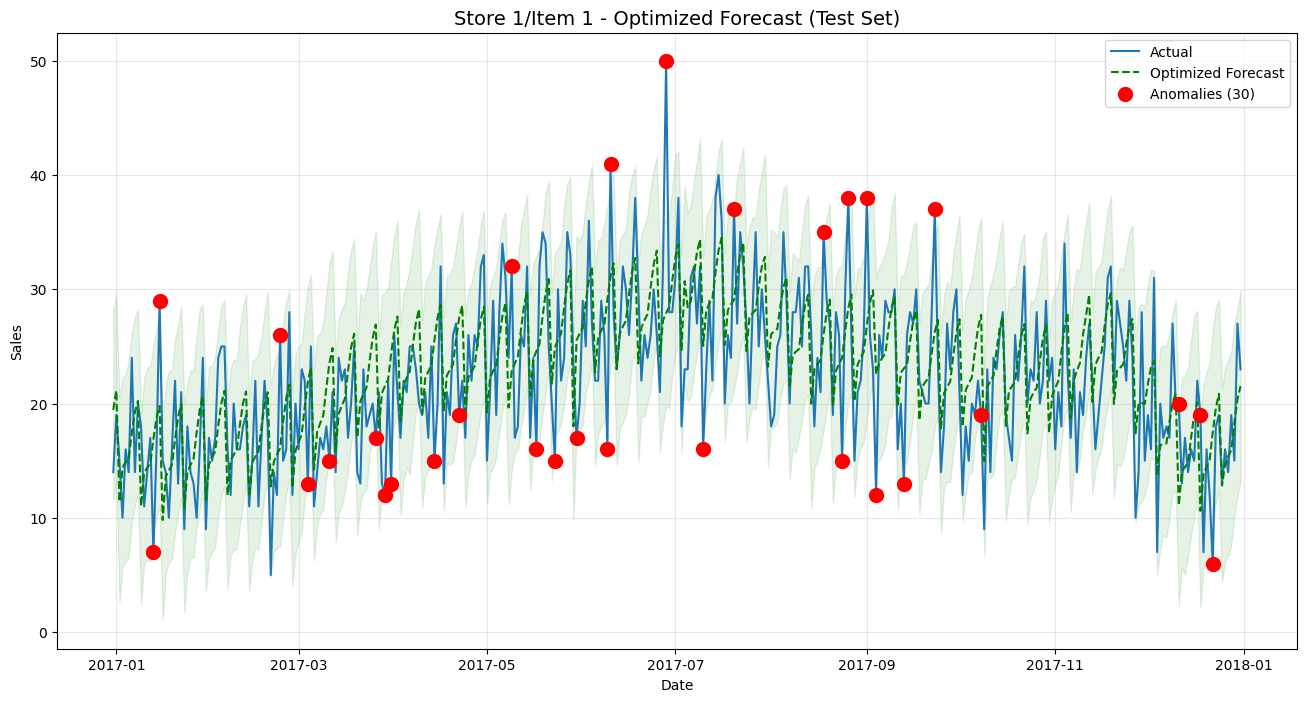

In [28]:
# --- Optimized Forecasting & Anomaly Detection ---
def analyze_item(store=1, item=1, test_size=0.2):
    # Filter data
    subset = df[(df.store == store) & (df.item == item)][['date', 'sales']]
    subset.columns = ['ds', 'y']
    
    # --- Add Floor & Cap ---
    subset['floor'] = 0  # Minimum sales can't be negative
    subset['cap'] = subset['y'].max() * 1.5  # Set cap to 1.5x historical max sales

    # Train-test split
    split_idx = int(len(subset) * (1 - test_size))
    train = subset.iloc[:split_idx]
    test = subset.iloc[split_idx:]
    
    # --- Hyperparameter Grid ---
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }
    
    # Generate all combinations
    params_list = [dict(zip(param_grid.keys(), v)) 
                   for v in product(*param_grid.values())]
    
    # --- Parallel Cross-Validation ---
    print(f"\nPerforming CV for {len(params_list)} parameter combinations...")
    results = []
    
    with joblib.Parallel(n_jobs=-1) as parallel:
        results = parallel(
            joblib.delayed(prophet_crossval)(train, params) 
            for params in params_list
        )
    
    # Find best parameters

    cv_results = pd.DataFrame(results).dropna(subset=['smape'])
    if len(cv_results) == 0:
        raise ValueError("All parameter combinations failed. Check data/model settings.")
    best_params = cv_results.loc[cv_results['smape'].idxmin()]['params']
    
    print(f"\nBest Parameters:")
    print(best_params)
    print(f"Best SMAPE: {cv_results['smape'].min():.2f}%")
    
    # --- Final Prophet Model ---
    final_model = Prophet(
        growth='logistic',  # Enable logistic growth
        interval_width=0.95,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode=best_params['seasonality_mode'],
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale']
    ).add_country_holidays('US')
    
    final_model.fit(train)
    
    # --- Forecast Test Period ---
    future = final_model.make_future_dataframe(periods=len(test))
    future['floor'] = 0  # Apply floor to future dates
    future['cap'] = subset['cap'].max()  # Carry forward cap
    forecast = final_model.predict(future)
    
    # --- Test-Set Evaluation ---
    test_forecast = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]\
                    .merge(test, on='ds', how='right')
    
    test_smape = smape_kun(test_forecast['y'], test_forecast['yhat'])
    print(f"\nTest Set SMAPE: {test_smape:.2f}%")
    
    # --- Anomaly Detection ---
    test_forecast['residual'] = test_forecast['y'] - test_forecast['yhat']
    std_dev = test_forecast['residual'].std()
    test_forecast['is_anomaly'] = (np.abs(test_forecast['residual']) > 3 * std_dev) | \
                                  (test_forecast['y'] > test_forecast['yhat_upper']) | \
                                  (test_forecast['y'] < test_forecast['yhat_lower'])
    
    # --- Visualization ---
    plt.figure(figsize=(16,8))
    plt.plot(test_forecast['ds'], test_forecast['y'], label='Actual')
    plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Optimized Forecast', 
             linestyle='--', color='green')
    plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], 
                     test_forecast['yhat_upper'], color='green', alpha=0.1)
    
    anomalies = test_forecast[test_forecast['is_anomaly']]
    plt.scatter(anomalies['ds'], anomalies['y'], color='red', s=100,
                label=f'Anomalies ({len(anomalies)})', zorder=5)
    
    plt.title(f'Store {store}/Item {item} - Optimized Forecast (Test Set)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    return test_forecast, cv_results

# --- Analysis ---
forecast_results, cv_results = analyze_item(store=1, item=1)

In [29]:
# --- PySpark Parallel Processing --- 
def run_spark_analysis():
    spark = SparkSession.builder \
        .master("local[*]") \
        .appName("SalesForecast") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

    # Prepare data
    spark_df = spark.createDataFrame(df.rename(columns={'date':'ds', 'sales':'y'}))
    
    # Schema for UDF
    schema = StructType([
        StructField('ds', TimestampType()),
        StructField('store', IntegerType()),
        StructField('item', IntegerType()),
        StructField('y', FloatType()),
        StructField('yhat', FloatType()),
        StructField('yhat_upper', FloatType()),
        StructField('yhat_lower', FloatType())
    ])

    @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
    def forecast_udf(group):
        model = Prophet(interval_width=0.95)
        model.fit(group[['ds', 'y']])
        future = model.make_future_dataframe(periods=90)
        forecast = model.predict(future)
        return forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]\
                   .merge(group[['ds', 'store', 'item', 'y']], on='ds', how='left')\
                   [schema.fieldNames()]

    return spark_df.groupby('store', 'item').apply(forecast_udf)

In [30]:
spark_results = run_spark_analysis()
spark_results.show(5)

/home/kapilaash/Project/.venv/lib/python3.12/site-packages/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
25/04/04 14:19:50 WARN TaskSetManager: Stage 3 contains a task of very large size (2006 KiB). The maximum recommended task size is 1000 KiB.
14:19:54 - cmdstanpy - INFO - Chain [1] start processing            (0 + 1) / 1]
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing


+-------------------+-----+----+----+----------+----------+----------+
|                 ds|store|item|   y|      yhat|yhat_upper|yhat_lower|
+-------------------+-----+----+----+----------+----------+----------+
|2013-01-01 00:00:00|    1|   3|15.0|-17.051105| 1.3323665| -34.68442|
|2013-01-02 00:00:00|    1|   3|30.0|  35.35639| 53.386543| 16.107416|
|2013-01-03 00:00:00|    1|   3|14.0|-5.6360836| 12.920996|-23.476967|
|2013-01-04 00:00:00|    1|   3|10.0|  -7.25969|  9.729631|-25.170515|
|2013-01-05 00:00:00|    1|   3|23.0| 31.018652|  48.66312| 13.327452|
+-------------------+-----+----+----+----------+----------+----------+
only showing top 5 rows



14:19:56 - cmdstanpy - INFO - Chain [1] start processing
14:19:56 - cmdstanpy - INFO - Chain [1] done processing
14:19:56 - cmdstanpy - INFO - Chain [1] start processing
14:19:56 - cmdstanpy - INFO - Chain [1] done processing
